In [71]:
import pandas as pd
import os
import regex as re
from datetime import datetime
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, spearmanr
import numpy as np
from lda import LDA
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.feature_extraction.text import CountVectorizer
ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))


# Correlation

array([<AxesSubplot:xlabel='EVENT_DATE'>,
       <AxesSubplot:xlabel='EVENT_DATE'>,
       <AxesSubplot:xlabel='EVENT_DATE'>,
       <AxesSubplot:xlabel='EVENT_DATE'>,
       <AxesSubplot:xlabel='EVENT_DATE'>,
       <AxesSubplot:xlabel='EVENT_DATE'>,
       <AxesSubplot:xlabel='EVENT_DATE'>], dtype=object)

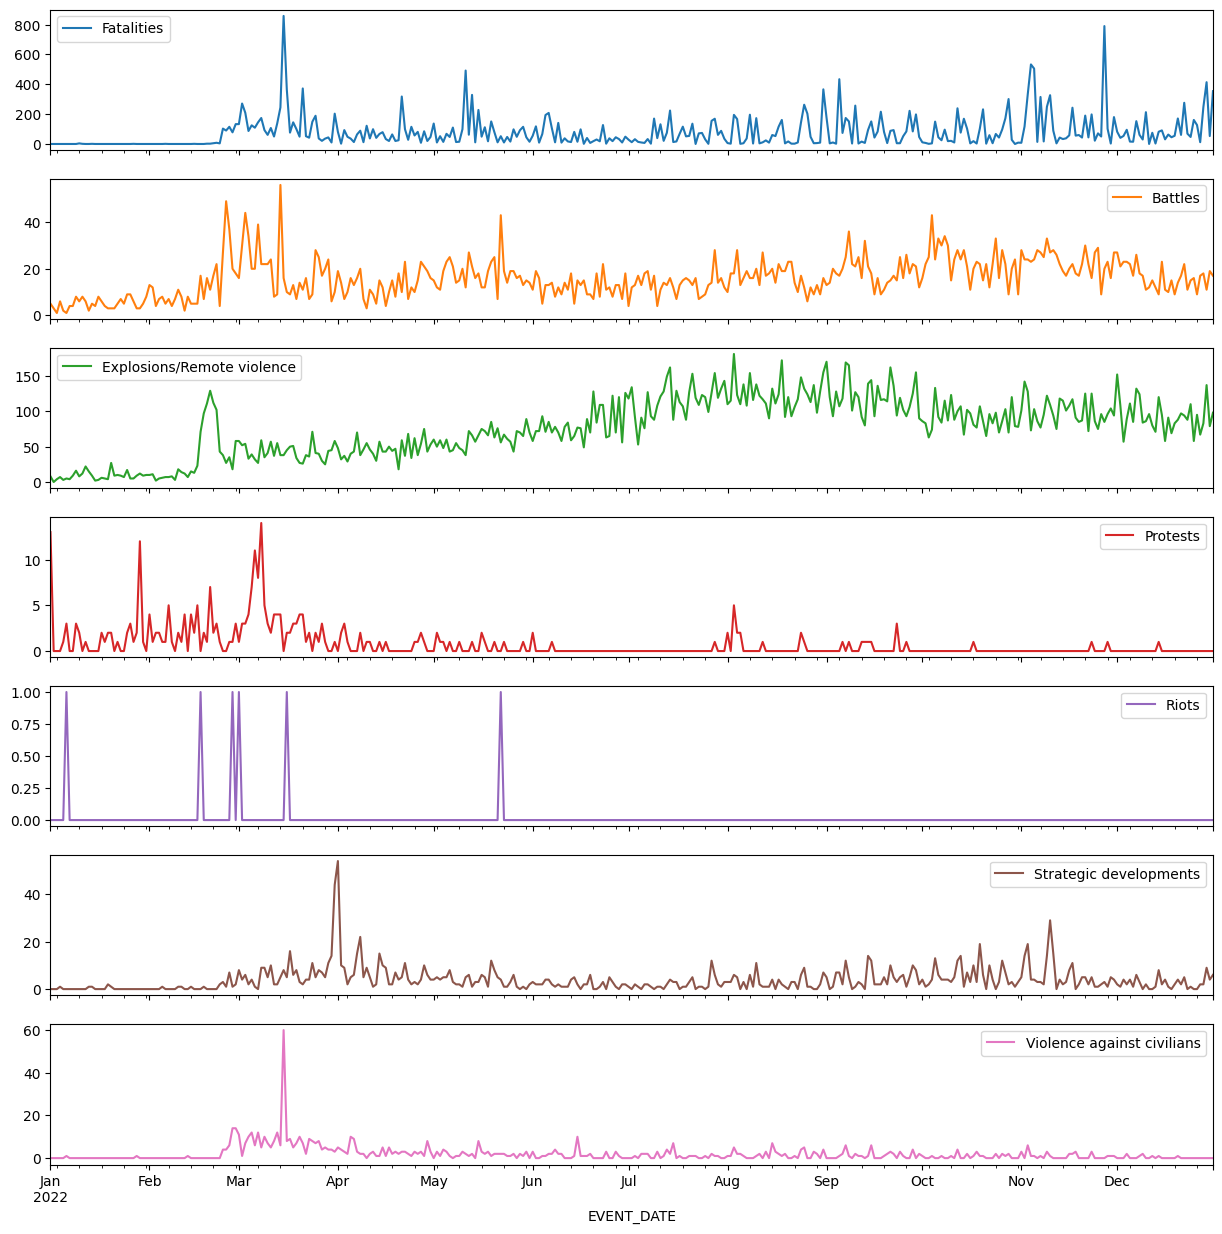

In [72]:

events = pd.read_csv(os.path.join(ROOT_DIR,"data","Ukraine_Black_Sea_2020_2023_Jan20.csv"), parse_dates=["EVENT_DATE"], index_col="EVENT_DATE")
events = events[["FATALITIES","EVENT_TYPE","LOCATION","NOTES"]].loc["2022-01-01":"2022-12-31"].sort_index()
# events = events.query("FATALITIES > 50")
# events.iloc[50:100,:]
events = events[["EVENT_TYPE","FATALITIES"]].rename(columns={"EVENT_DATE":"Date","EVENT_TYPE":"Count","FATALITIES":"Fatalities"})  # pegando somente colunas relevantes
events = pd.get_dummies(events, columns=["Count"], prefix="", prefix_sep="")  # transformando em dummies
events = events.resample("D").sum()

# plot all columns in events
events.plot(subplots=True, figsize=(15,15))


In [73]:
scales = [1, 2, 3, 4, 5, 7, 9, 10, 13, 19, 26, 37, 51, 71, 100, 138, 193, 268, 372, 517,719,1000]
df_ntr = pd.DataFrame()
for scale in scales:
    df = pd.read_csv(os.path.join(ROOT_DIR,"multiscale_results",f"results_{scale}","All_Results.csv"), index_col="Date", parse_dates=["Date"])
    df = df.filter(["Resonance","Novelty","Transience"])
    df = df.rename(columns={"Resonance":f"Resonance_{scale}","Novelty":f"Novelty_{scale}","Transience":f"Transience_{scale}"})
    df_ntr = pd.concat([df_ntr, df], axis=1)

In [74]:
pvalues = []
for scale in scales:
    resonance = df_ntr[f"Resonance_{scale}"]
    novelty = df_ntr[f"Novelty_{scale}"]
    #regress y= resoance on x= novelty
    model = smf.ols(formula=f"Resonance_{scale} ~ Novelty_{scale}", data=df_ntr)
    results = model.fit()
    pvalues.append(results.pvalues[1])
    # get list of predicted values of resonance
    df_ntr[f"Resonance_{scale}_predicted"] = results.predict(df_ntr[f"Novelty_{scale}"])
    df_ntr[f"Resonance_{scale}_delta"] = df_ntr[f"Resonance_{scale}"] - df_ntr[f"Resonance_{scale}_predicted"]
#print(pvalues)


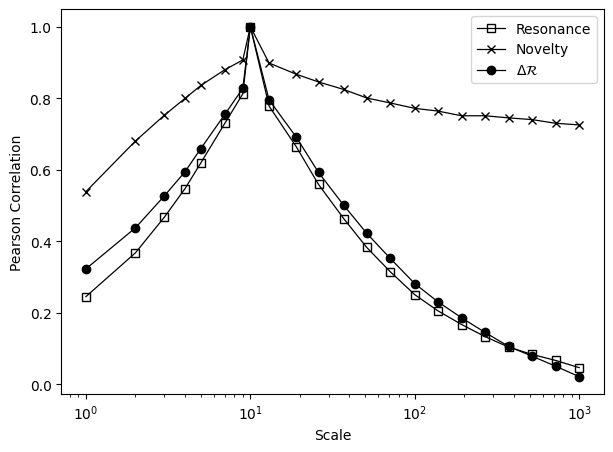

In [76]:
df_ntr_crop = df_ntr.iloc[1000:-1000,:]
df_ntr_crop.head(60)
p_resonance = [pearsonr(df_ntr_crop["Resonance_10"], df_ntr_crop[f"Resonance_{scale}"])[0] for scale in scales]
p_novelty = [pearsonr(df_ntr_crop["Novelty_10"], df_ntr_crop[f"Novelty_{scale}"])[0] for scale in scales]
p_transience = [pearsonr(df_ntr_crop["Transience_10"], df_ntr_crop[f"Transience_{scale}"])[0] for scale in scales]
p_delta = [pearsonr(df_ntr_crop["Resonance_10_delta"], df_ntr_crop[f"Resonance_{scale}_delta"])[0] for scale in scales]

df_all = pd.DataFrame({"Scale":scales, "Resonance":p_resonance, "Novelty":p_novelty, "Transience":p_transience, "Resonance_delta":p_delta})
df_all = df_all.set_index("Scale")

def corr_plot():
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(df_all.index.values, df_all["Resonance"], label="Resonance", marker="s", fillstyle="none", lw=0.9,c="k")
    ax.plot(df_all.index.values, df_all["Novelty"], label="Novelty", marker="x", lw=0.9,c="k")
    ax.plot(df_all.index.values, df_all[f"Resonance_delta"], label="\u0394$\mathcal{R}$", marker="o", lw=0.9,c="k")
    #ax.plot(df_all.index.values, df_all["Transience"], label="Transience", marker="s")
    ax.set_xscale("log")
    ax.set_xlabel("Scale")
    ax.set_ylabel("Pearson Correlation")
    ax.legend()
    plt.show()

corr_plot()